In [1]:
%run "RBM.ipynb"

class RBM_Classification(RBM):
    # n_k is the number of classes
    def __init__(self, n_x, n_h, n_k, n_d=1, W=None, b=None, c=None, k=1):
        self.n_x = n_x
        self.n_k = n_k
        self.n_d = n_d  
        # label is represented with n_k*n_d dots, where label i is the i-th group of n_d dots
        # np.zeros(n_k*n_d)[i*n_d:+n_d] = 1
        super().__init__(n_x+n_k*n_d, n_h, W, b, c, k)
        return
        
    def convert_input(self, X, Label):
        n_sample = X.shape[0]
        n_k = self.n_k; n_d = self.n_d; n_x = self.n_x
        assert X.shape == (n_sample, n_x)

        if Label is not None:
            Label = Label.flatten()
            #attach label to data
            Y = np.zeros(shape=(n_sample, n_k))
            Index = np.arange(n_sample)
            Y[Index, Label] = 1
            Y = Y.repeat(n_d, axis=1)
        else:
            Y = np.zeros(shape=(n_sample, n_k*n_d))

        V = np.append(X, Y, axis=1)
        assert V.shape == (n_sample, self.n_v)        
        return V

    # this is the API for app to use
    def train(self, X, Label, n_epoch=1, batch_size=10, learning=0.01, save_file=None):
        if self.training_done: return

        save_file = save_file + ".rbm_classify"
        V = self.convert_input(X, Label)
        self.train_model(V, n_epoch, batch_size, learning, save_file)

        self.training_done = True
        return

    def classify(self, x):
        #set_trace()
        x = x.reshape(1,-1)
        v = self.convert_input(x, None)
        vp, vs = super().reconstruct(v)

        n_k = self.n_k; n_d = self.n_d; n_x = self.n_x
        result = vp[0, n_x:]
        result = result.reshape(n_k, -1).sum(axis=1) # collapse the k*d dots into k sum dots.
        pred = np.argmax(result)

        return vp[0, :n_x], pred
    
    def create_label_input(self, label, weight):
        n_k = self.n_k; n_d = self.n_d
        classes = np.zeros(n_k)
        classes[label] = weight
        classes = classes.repeat(n_d)
        return classes

    def reconstruct(self, x, label, k_gibbs, init_w, w):
        # this is a very simple generation algorithm with single-layer RBM
        classes = self.create_label_input(label, init_w)
        v = np.append(x, classes)
        vp = v.reshape(1,-1)
        
        classes = self.create_label_input(label, w)
        n_x = self.n_x
        for i in range(k_gibbs):
            vp, vs = super().reconstruct(vp)
            vp[0, n_x:] = classes

        return vp[0, :n_x]
            
    def reconstruct_from_label(self, label, k_gibbs, init_w, w):
        # this is a very simple generation algorithm with single-layer RBM        
        n_x = self.n_x
        #np.random.seed(1234)
        #x = np.random.binomial(1, 0.2, n_x)
        #x = np.zeros(n_x)
        #x = np.random.uniform(0, 0.8, n_x)
        x = np.full(n_x, 0.1)
        v = self.reconstruct(x, label, k_gibbs, init_w, w)
        return v

    def save_model(self, save_file):
        dict = {'n_x':self.n_x, 'n_h':self.n_h, 'n_k':self.n_k, 'n_d':self.n_d, 'W':self.W, 'b':self.b, 'c':self.c}
        save_file += ".("+ str(self.n_x) + "+" + str(self.n_k) + "x" + str(self.n_d) + ")x" + str(self.n_h)
        with open(save_file, 'wb') as f:
            pickle.dump(dict, f, protocol=pickle.HIGHEST_PROTOCOL)

        return

    @classmethod
    def load_model(cls, load_file):
        with open(load_file, 'rb') as f:
            m = pickle.load(f)

        rbm = cls(m['n_x'], m['n_h'], m['n_k'], m['n_d'], m['W'], m['b'], m['c'])
        return rbm

In [5]:
# testing of the RBM Classification_Generation code above

%run "mnist.ipynb"
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Grid
import math

class MNIST_RBM_CLASSIFY:
    def __init__(self, n_x, n_h, n_k=10, n_d=1, load_file=None, folder="convolution-network"):

        if load_file is None:
            self.net= RBM_Classification(n_x, n_h, n_k, n_d)
        else:
            self.net = RBM_Classification.load_model(load_file)
            
        self.train_input = MnistInput("train", folder)
        self.test_input = MnistInput("test", folder)

        return

    def train(self, train_size=-1, n_epoch=100, batch_size=10, learning=0.1):
        if self.net.training_done: return
        
        X = []; Y=[]
        n_x = 0
        for x, y in self.train_input.read(train_size):
            X.append(x)
            Y.append(y)
            n_x += 1

        X = (np.array(X).reshape(n_x, -1) > 30)*1
        Label = np.array(Y).reshape(n_x, -1)
        
        self.net.train(X, Label, n_epoch, batch_size, learning, save_file="mnist")
        return

    def classify(self, test_size=-1, output_size=20):
        n_total=0; n_correct = 0; n_output = 0
        X=[]; Y=[]; Recon=[]; Preds=[]
        for x, y in self.test_input.read(test_size):
            n_total += 1
            reco, pred = self.net.classify(x/255)
            if y == pred: n_correct += 1 
            if n_output < output_size:
                Preds.append(pred)
                Recon.append(reco)
                X.append(x)
                Y.append(y)
                n_output += 1

        accuracy = n_correct/n_total
        print("Classification accuracy: {}".format(accuracy))

        # output
        d = 28
        ncols = 10
        nrows = int(output_size/5)
        fig = plt.figure(figsize=(ncols, int(nrows*2)), dpi=100)
        grid = Grid(fig, rect=111, nrows_ncols=(nrows,ncols))

        for i, ax in enumerate(grid):
            j = i//2
            if i%2 == 0:
                ax.imshow(X[j].reshape(d,d), cmap=mpl.cm.Greys)
                ax.set_title("Orig: {}".format(Y[j]), y=0)
            else:
                ax.imshow(Recon[j].reshape(d,d), cmap=mpl.cm.Greys)
                ax.set_title("Reco: {}".format(Preds[j]), y=0)

            ax.set_axis_off()

        fig.text(0.5,1, "Classified images and reconstructed digits", fontsize=20, horizontalalignment='center')
        fig.tight_layout()
        plt.show()        
        return
    
    def generate(self, k_gibbs=50, init_w=30, w=30, n_k=10):
        # 50,30,30 is for mnist_rbm_classify.(784+10)x85.epochs100
        digits = []
        for i in range( n_k ):
            digit = self.net.reconstruct_from_label(i, k_gibbs, init_w, w)
            digits.append(digit)
        
        # output
        d = 28
        ncols = n_k
        nrows = 1
        fig = plt.figure(figsize=(ncols, int(nrows*2)), dpi=100)
        grid = Grid(fig, rect=111, nrows_ncols=(nrows,ncols))

        for i, ax in enumerate(grid):
            ax.imshow(digits[i].reshape(d,d), cmap=mpl.cm.Greys)
            ax.set_title(i)
            ax.set_axis_off()

        fig.suptitle('Generated digit images from numbers')
        fig.tight_layout()
        fig.subplots_adjust(top=0.7)    
        plt.show()        
        return



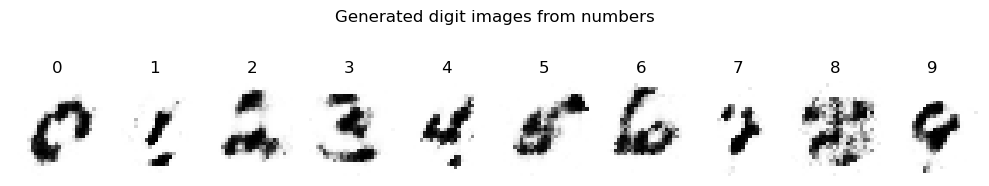

In [6]:
mnist = None
if __name__ == "__main__" and '__file__' not in globals():
    np.seterr(all='raise')
    mnist = MNIST_RBM_CLASSIFY(28*28, n_h=28*3+1, load_file="trained_models/mnist_rbm_classify.epochs10.(784+10)x85")
    #mnist = MNIST_RBM_CLASSIFY(28*28, n_h=28*20+1)
    #mnist.train(train_size=1000, n_epoch=2, batch_size=10, learning=0.1)
    plt.close('all')
    #mnist.classify()
    mnist.generate(20,50,8)

Classification accuracy: 0.9166


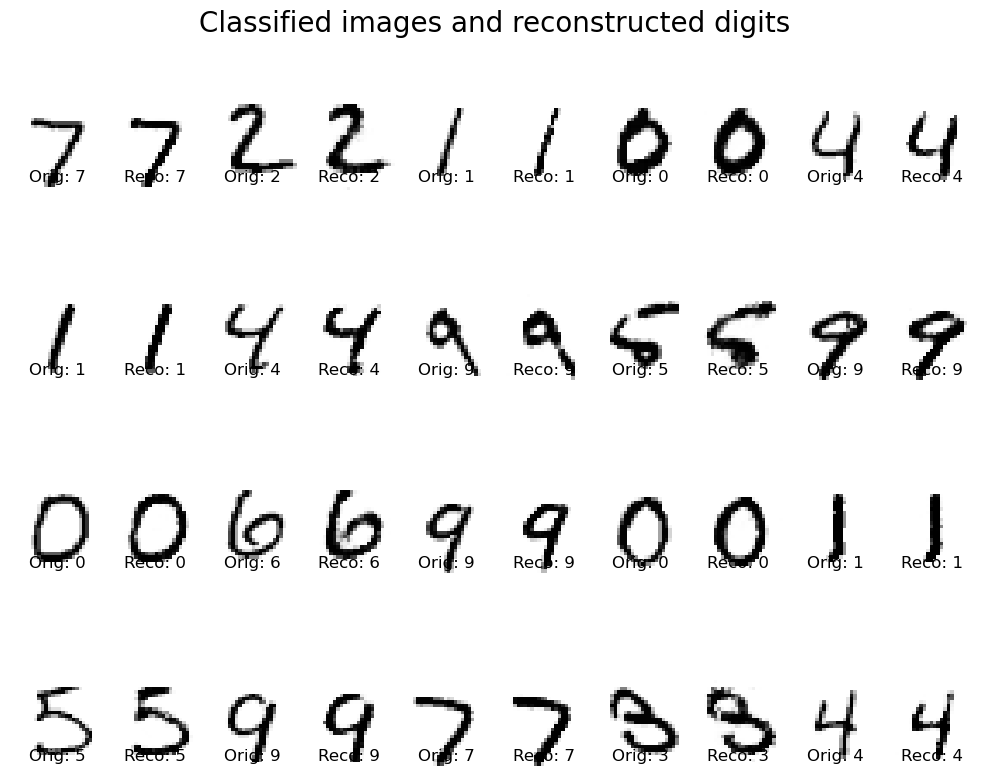

In [7]:
mnist = None
if __name__ == "__main__" and '__file__' not in globals():
    np.seterr(all='raise')
    mnist = MNIST_RBM_CLASSIFY(28*28, n_h=28*20+1, load_file="trained_models/mnist_rbm_classify.(784+10)x561.epochs100")
    #mnist = MNIST_RBM_CLASSIFY(28*28, n_h=28*20+1)
    mnist.train(train_size=1000, n_epoch=2, batch_size=10, learning=0.1)
    plt.close('all')
    mnist.classify()
    #mnist.generate(10,5,5)